# TFT Match Analysis: Statistical Investigation of Trait Effects and Match Outcomes

## Research Questions
1. **RQ1 (Descriptive)**: What is the distribution of placements, win rate, and Top-4 rate across 200 TFT matches?
2. **RQ2 (Chi-Square)**: Is there a significant association between specific trait presence and achieving a Top-4 finish?
3. **RQ3 (t-test)**: Do players who achieve Top-4 finishes have significantly different in-game metrics (level, gold left, damage dealt) compared to non-Top-4 players?
4. **RQ4 (ANOVA - Optional)**: Do in-game metrics vary significantly across different placement tiers?

## Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import chi2_contingency, ttest_ind, f_oneway
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Set style for better visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## Load and Explore Data

In [ ]:
df = pd.read_csv("INNO-TFT-Dataset.csv")
print(f"Dataset shape: {df.shape}")
print(f"\nColumn names:\n{df.columns.tolist()}")
df.head()

Dataset shape: (200, 19)

Column names:
['match_id', 'game_datetime', 'game_length', 'game_version', 'queue_id', 'tft_game_type', 'tft_set_core_name', 'tft_set_number', 'placement', 'level', 'gold_left', 'last_round', 'players_eliminated', 'time_eliminated', 'total_damage_to_players', 'win', 'companion', 'traits', 'units']


,match_id,game_datetime,game_length,game_version,queue_id,tft_game_type,tft_set_core_name,tft_set_number,placement,level,gold_left,last_round,players_eliminated,time_eliminated,total_damage_to_players,win,companion,traits,units
0,SG2_134110128,1.770660e+12,2259.656250,Linux Version 16.3.744.7656 (Feb 06 2026/10:38...,1100,standard,TFTSet16,16,5,9,1,33,2,2003.823486,101,False,{'content_ID': 'b3368207-0065-48e6-a909-0ab69d...,"TFT16_AurelionSolUnique(units=1,style=3,tier=1...",TFT16_Neeko(tier=2)[items=][itemNames=]; TFT16...
1,SG2_133989965,1.770630e+12,2351.530029,Linux Version 16.3.744.7656 (Feb 06 2026/10:38...,1100,standard,TFTSet16,16,4,8,38,31,1,1921.549805,87,True,{'content_ID': 'b3368207-0065-48e6-a909-0ab69d...,"TFT16_AurelionSolUnique(units=1,style=3,tier=1...",TFT16_Neeko(tier=2)[items=][itemNames=]; TFT16...
2,SG2_133870769,1.770570e+12,2174.458984,Linux Version 16.3.744.7656 (Feb 06 2026/10:38...,1100,standard,TFTSet16,16,1,9,2,38,4,2166.248047,184,True,{'content_ID': 'b3368207-0065-48e6-a909-0ab69d...,"TFT16_Blacksmith(units=1,style=3,tier=1/1); TF...",TFT16_Viego(tier=3)[items=][itemNames=TFT_Item...
3,SG2_133864702,1.770570e+12,2127.833740,Linux Version 16.3.744.7656 (Feb 06 2026/10:38...,1100,standard,TFTSet16,16,8,8,50,20,0,1153.692993,0,False,{'content_ID': 'b3368207-0065-48e6-a909-0ab69d...,"TFT16_Bilgewater(units=1,style=0,tier=0/4); TF...",TFT16_Shen(tier=2)[items=][itemNames=]; TFT16_...
4,SG2_133859591,1.770570e+12,2234.131836,Linux Version 16.3.744.7656 (Feb 06 2026/10:38...,1100,standard,TFTSet16,16,8,7,57,21,0,1229.684082,0,False,{'content_ID': 'b3368207-0065-48e6-a909-0ab69d...,"TFT16_Defender(units=1,style=0,tier=0/3); TFT1...",TFT16_Qiyana(tier=2)[items=][itemNames=]; TFT1...


In [ ]:
# Create binary outcome variables
df["top4"] = (df["placement"] <= 4).astype(int)
df["win"] = (df["placement"] == 1).astype(int)

print("Data types:")
print(df.dtypes)
print("\nFirst few rows with new variables:")
df[["placement", "top4", "win", "level", "gold_left", "total_damage_to_players"]].head(10)

Data types:
match_id                    object
game_datetime              float64
game_length                float64
game_version                object
queue_id                     int64
tft_game_type               object
tft_set_core_name           object
tft_set_number               int64
placement                    int64
level                        int64
gold_left                    int64
last_round                   int64
players_eliminated           int64
time_eliminated            float64
total_damage_to_players      int64
win                          int64
companion                   object
traits                      object
units                       object
top4                         int64
dtype: object

First few rows with new variables:


,placement,top4,win,level,gold_left,total_damage_to_players
0,5,0,0,9,1,101
1,4,1,0,8,38,87
2,1,1,1,9,2,184
3,8,0,0,8,50,0
4,8,0,0,7,57,0
5,2,1,0,9,9,160
6,3,1,0,7,49,75
7,1,1,1,9,7,162
8,5,0,0,8,34,93
9,4,1,0,9,0,108


---
# RESEARCH QUESTION 1: Descriptive Statistics & Distribution

### RQ1: What is the distribution of placements, win rate, and Top-4 rate across 200 TFT matches?

In [ ]:
# Summary statistics
summary = {
    "Total Games": len(df),
    "Win Rate": df["win"].mean(),
    "Top-4 Rate": df["top4"].mean(),
    "Mean Placement": df["placement"].mean(),
    "Median Placement": df["placement"].median(),
    "Std Dev Placement": df["placement"].std(),
    "Min Placement": df["placement"].min(),
    "Max Placement": df["placement"].max()
}

summary_series = pd.Series(summary)
print("="*60)
print("SUMMARY STATISTICS")
print("="*60)
print(summary_series)
print("\n" + "="*60)
print(f"Expected win rate (random): {1/8:.3f}")
print(f"Expected Top-4 rate (random): {4/8:.3f}")
print("="*60)

SUMMARY STATISTICS
Total Games          200.000000
Win Rate               0.225000
Top-4 Rate             0.510000
Mean Placement         4.435000
Median Placement       4.000000
Std Dev Placement      2.572716
Min Placement          1.000000
Max Placement          8.000000
dtype: float64

Expected win rate (random): 0.125
Expected Top-4 rate (random): 0.500


In [ ]:
# Detailed descriptive statistics
print("\nDETAILED DESCRIPTIVE STATISTICS:")
print("="*60)
print(df[["placement", "top4", "win", "level", "gold_left", "total_damage_to_players"]].describe())

# Quartile breakdown
print("\n" + "="*60)
print("QUARTILE ANALYSIS - PLACEMENT:")
print("="*60)
print(df["placement"].quantile([0, 0.25, 0.5, 0.75, 1.0]))


DETAILED DESCRIPTIVE STATISTICS:
        placement        top4        win      level   gold_left  \
count  200.000000  200.000000  200.00000  200.00000  200.000000   
mean     4.435000    0.510000    0.22500    8.39500   20.360000   
std      2.572716    0.501154    0.41863    0.98173   22.566271   
min      1.000000    0.000000    0.00000    5.00000    0.000000   
25%      2.000000    0.000000    0.00000    8.00000    2.000000   
50%      4.000000    1.000000    0.00000    8.00000   12.000000   
75%      7.000000    1.000000    0.00000    9.00000   37.000000   
max      8.000000    1.000000    1.00000   10.00000  168.000000   

       total_damage_to_players  
count               200.000000  
mean                101.115000  
std                  62.971492  
min                   0.000000  
25%                  49.750000  
50%                  90.000000  
75%                 150.750000  
max                 245.000000  

QUARTILE ANALYSIS - PLACEMENT:
0.00    1.0
0.25    2.0
0.50    4

In [ ]:
# Placement frequency distribution
print("\nPLACEMENT FREQUENCY DISTRIBUTION:")
print("="*60)
placement_counts = df['placement'].value_counts().sort_index()
placement_pct = (placement_counts / len(df) * 100).round(2)
placement_table = pd.DataFrame({
    'Count': placement_counts,
    'Percentage': placement_pct,
    'Expected_Random_%': 12.5
})
print(placement_table)
print("\nNote: In an 8-player game, random chance = 12.5% per placement")


PLACEMENT FREQUENCY DISTRIBUTION:
           Count  Percentage  Expected_Random_%
placement                                      
1             45        22.5               12.5
2             17         8.5               12.5
3             13         6.5               12.5
4             27        13.5               12.5
5             22        11.0               12.5
6             15         7.5               12.5
7             27        13.5               12.5
8             34        17.0               12.5

Note: In an 8-player game, random chance = 12.5% per placement


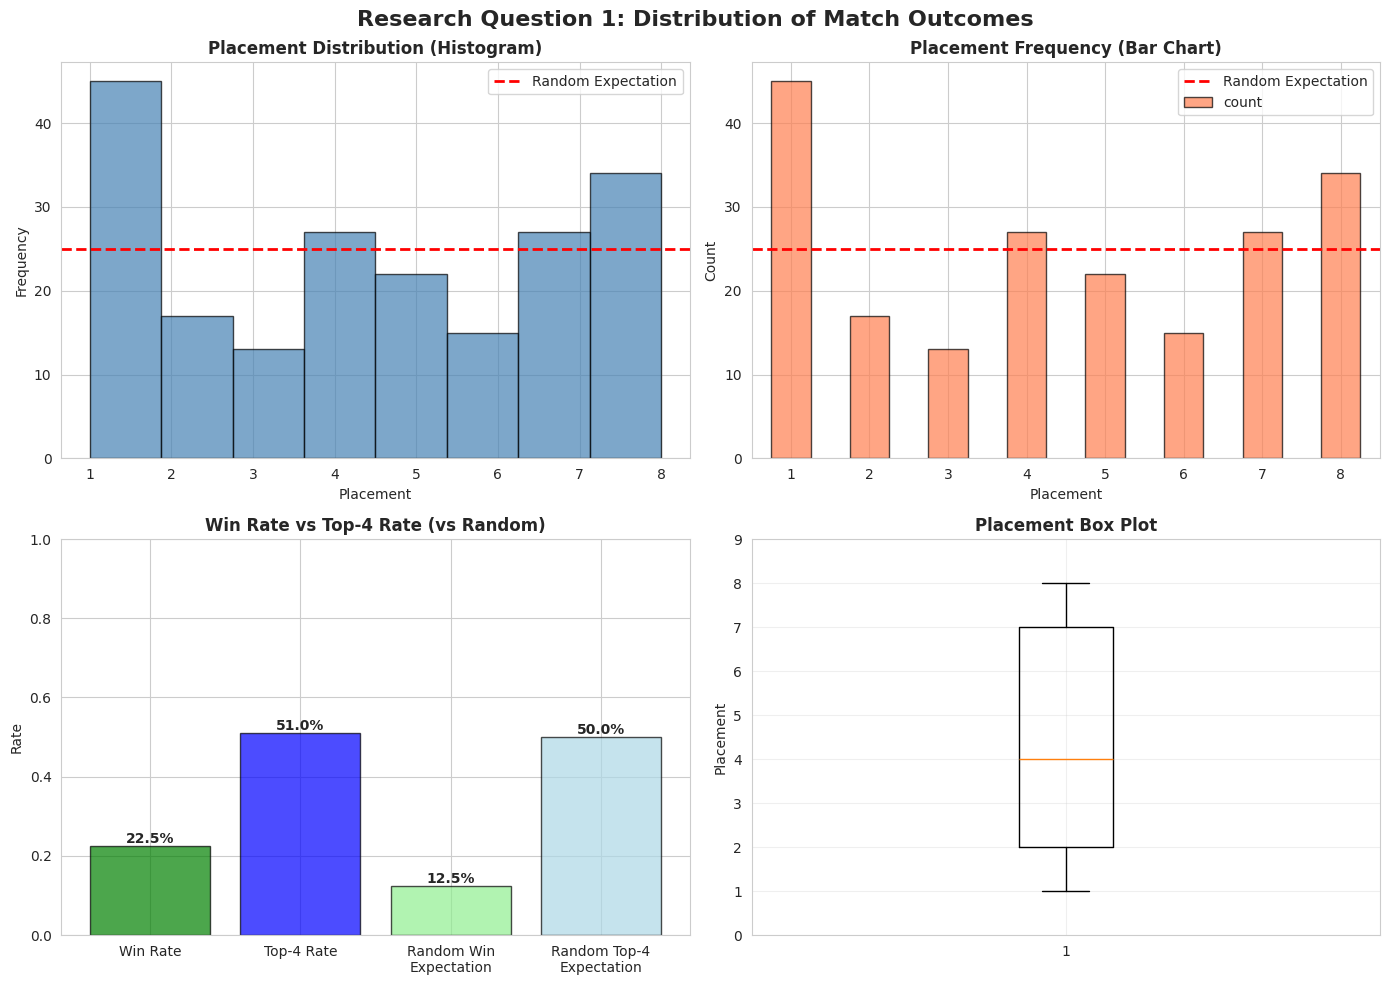


✓ RQ1 Visualizations complete


In [ ]:
# Visualizations for RQ1
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Research Question 1: Distribution of Match Outcomes', fontsize=16, fontweight='bold')

# Plot 1: Placement histogram
axes[0, 0].hist(df["placement"], bins=8, color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Placement Distribution (Histogram)', fontweight='bold')
axes[0, 0].set_xlabel('Placement')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axhline(y=len(df)/8, color='red', linestyle='--', linewidth=2, label='Random Expectation')
axes[0, 0].legend()

# Plot 2: Placement bar chart
placement_counts.plot(kind='bar', ax=axes[0, 1], color='coral', edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Placement Frequency (Bar Chart)', fontweight='bold')
axes[0, 1].set_xlabel('Placement')
axes[0, 1].set_ylabel('Count')
axes[0, 1].axhline(y=len(df)/8, color='red', linestyle='--', linewidth=2, label='Random Expectation')
axes[0, 1].legend()
axes[0, 1].set_xticklabels(range(1, 9), rotation=0)

# Plot 3: Win vs Top-4 rates
outcomes = ['Win Rate', 'Top-4 Rate', 'Random Win\nExpectation', 'Random Top-4\nExpectation']
rates = [df["win"].mean(), df["top4"].mean(), 1/8, 4/8]
colors = ['green', 'blue', 'lightgreen', 'lightblue']
bars = axes[1, 0].bar(outcomes, rates, color=colors, edgecolor='black', alpha=0.7)
axes[1, 0].set_title('Win Rate vs Top-4 Rate (vs Random)', fontweight='bold')
axes[1, 0].set_ylabel('Rate')
axes[1, 0].set_ylim(0, 1)
for i, bar in enumerate(bars):
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{rates[i]:.1%}', ha='center', va='bottom', fontweight='bold')

# Plot 4: Box plot of placement
axes[1, 1].boxplot(df['placement'], vert=True)
axes[1, 1].set_title('Placement Box Plot', fontweight='bold')
axes[1, 1].set_ylabel('Placement')
axes[1, 1].set_ylim(0, 9)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ RQ1 Visualizations complete")

---
# DATA PREPARATION: Extract and Parse Traits

In [ ]:
# Parse trait data from raw string format
trait_list = []

for idx, row in df.iterrows():
    traits = row["traits"].split("; ")
    for t in traits:
        trait_name = t.split("(")[0]  # Extract trait name before parentheses
        trait_list.append({
            "match_id": row["match_id"],
            "trait": trait_name,
            "placement": row["placement"],
            "top4": row["top4"],
            "win": row["win"],
            "level": row["level"],
            "gold_left": row["gold_left"],
            "total_damage_to_players": row["total_damage_to_players"]
        })

traits_df = pd.DataFrame(trait_list)
print(f"Total trait instances: {len(traits_df)}")
print(f"Unique traits: {traits_df['trait'].nunique()}")
print(f"\nFirst 10 rows:")
print(traits_df.head(10))

Total trait instances: 2080
Unique traits: 66

First 10 rows:
        match_id                    trait  placement  top4  win  level  \
0  SG2_134110128  TFT16_AurelionSolUnique          5     0    0      9   
1  SG2_134110128          TFT16_DarkChild          5     0    0      9   
2  SG2_134110128           TFT16_Defender          5     0    0      9   
3  SG2_134110128           TFT16_Explorer          5     0    0      9   
4  SG2_134110128              TFT16_Ionia          5     0    0      9   
5  SG2_134110128         TFT16_Juggernaut          5     0    0      9   
6  SG2_134110128              TFT16_Noxus          5     0    0      9   
7  SG2_134110128      TFT16_ShyvanaUnique          5     0    0      9   
8  SG2_134110128           TFT16_Sorcerer          5     0    0      9   
9  SG2_134110128         TFT16_SylasTrait          5     0    0      9   

   gold_left  total_damage_to_players  
0          1                      101  
1          1                      101  
2  

---
# RESEARCH QUESTION 2: Chi-Square Test

### RQ2: Is there a significant association between specific trait presence and achieving a Top-4 finish?

In [ ]:
# Calculate trait statistics
trait_stats = traits_df.groupby("trait").agg(
    games=("placement", "count"),
    mean_placement=("placement", "mean"),
    top4_rate=("top4", "mean"),
    win_rate=("win", "mean")
).sort_values("games", ascending=False)

# Filter to traits with at least 10 occurrences
trait_stats = trait_stats[trait_stats["games"] >= 10]

print(f"\nTraits with 10+ occurrences: {len(trait_stats)}")
print(f"\nTraits sorted by Top-4 Rate (descending):")
print("="*80)
trait_stats_sorted = trait_stats.sort_values("top4_rate", ascending=False)
print(trait_stats_sorted[["games", "top4_rate", "win_rate", "mean_placement"]].round(4))


Traits with 10+ occurrences: 36

Traits sorted by Top-4 Rate (descending):
                         games  top4_rate  win_rate  mean_placement
trait                                                              
TFT16_KindredUnique         10     1.0000    0.5000          2.0000
TFT16_Soulbound             12     0.8333    0.3333          3.0833
TFT16_ShyvanaUnique         62     0.8065    0.4677          2.6774
TFT16_RuneMage              18     0.7778    0.7222          2.2222
TFT16_DarkChild             38     0.7632    0.3684          3.1316
TFT16_SylasTrait            66     0.7424    0.3030          3.3333
TFT16_HexMech               11     0.7273    0.1818          3.5455
TFT16_TheBoss               25     0.7200    0.6000          2.8000
TFT16_Blacksmith            25     0.6400    0.2000          4.1600
TFT16_Freljord              27     0.6296    0.2593          3.9259
TFT16_DarkinWeapon          15     0.6000    0.2667          3.7333
TFT16_Noxus                 97     0.597

In [ ]:
# Chi-Square Test for Association: Trait Presence vs Top-4 Achievement
print("\n" + "="*80)
print("CHI-SQUARE TEST: TRAIT PRESENCE vs TOP-4 ACHIEVEMENT")
print("="*80)
print("\nNull Hypothesis (H0): Trait presence is independent of Top-4 achievement")
print("Alternative Hypothesis (H1): Trait presence is associated with Top-4 achievement")
print("Significance Level: α = 0.05")
print("\n" + "-"*80)

chi_square_results = []

for trait in trait_stats.sort_values("top4_rate", ascending=False).index:
    # Create contingency table: trait presence (yes/no) vs top4 (yes/no)
    has_trait = traits_df[traits_df['trait'] == trait]['top4'].value_counts()
    no_trait = traits_df[traits_df['trait'] != trait]['top4'].value_counts()

    contingency = pd.crosstab(
        traits_df['trait'] == trait,
        traits_df['top4']
    )

    chi2, p_value, dof, expected = chi2_contingency(contingency)

    is_significant = "Yes" if p_value < 0.05 else "No"

    chi_square_results.append({
        'Trait': trait,
        'Games': int(traits_df[traits_df['trait'] == trait].shape[0]),
        'Chi-Square': chi2,
        'P-Value': p_value,
        'Significant (α=0.05)': is_significant,
        'Top4_Rate': trait_stats.loc[trait, 'top4_rate']
    })

chi_square_df = pd.DataFrame(chi_square_results).sort_values('P-Value')
print("\nRESULTS (sorted by P-value):")
print(chi_square_df.to_string(index=False))

# Significant traits
significant_traits = chi_square_df[chi_square_df['Significant (α=0.05)'] == 'Yes']
print(f"\n\nSignificant traits (p < 0.05): {len(significant_traits)}")
if len(significant_traits) > 0:
    print("\nTraits with significant association to Top-4:")
    print(significant_traits[['Trait', 'P-Value', 'Top4_Rate']].to_string(index=False))


CHI-SQUARE TEST: TRAIT PRESENCE vs TOP-4 ACHIEVEMENT

Null Hypothesis (H0): Trait presence is independent of Top-4 achievement
Alternative Hypothesis (H1): Trait presence is associated with Top-4 achievement
Significance Level: α = 0.05

--------------------------------------------------------------------------------

RESULTS (sorted by P-value):
                  Trait  Games  Chi-Square  P-Value Significant (α=0.05)  Top4_Rate
    TFT16_ShyvanaUnique     62   16.106323 0.000060                  Yes   0.806452
          TFT16_Demacia     50   16.052514 0.000062                  Yes   0.260000
       TFT16_SylasTrait     66    9.552257 0.001997                  Yes   0.742424
    TFT16_KindredUnique     10    6.539051 0.010553                  Yes   1.000000
        TFT16_DarkChild     38    6.342610 0.011787                  Yes   0.763158
       TFT16_Bilgewater     33    3.902616 0.048211                  Yes   0.363636
           TFT16_Slayer     24    3.704924 0.054252           

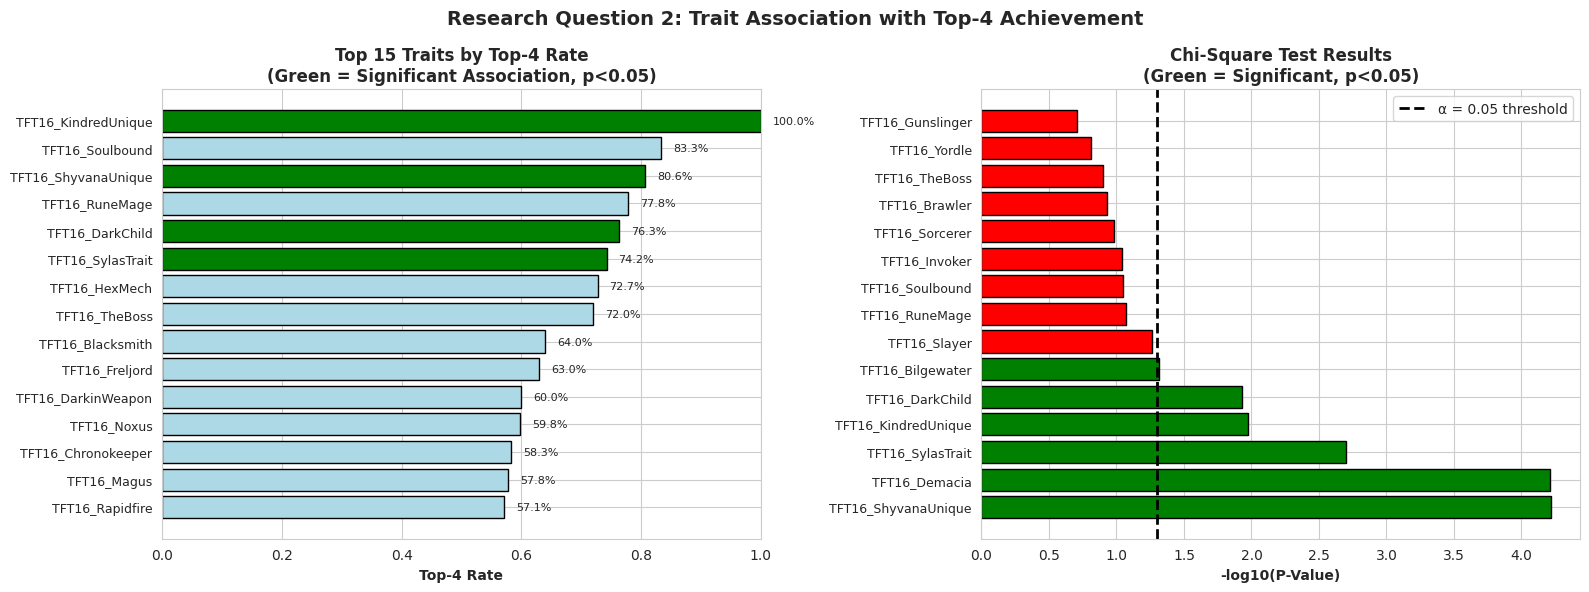


✓ RQ2 Visualizations complete


In [ ]:
# Visualizations for RQ2
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Research Question 2: Trait Association with Top-4 Achievement', fontsize=14, fontweight='bold')

# Plot 1: Top 15 traits by Top-4 rate
top15_traits = trait_stats.sort_values("top4_rate", ascending=True).tail(15)
colors_top4 = ['green' if p < 0.05 else 'lightblue' for p in
               [chi_square_df[chi_square_df['Trait'] == t]['P-Value'].values[0]
                if t in chi_square_df['Trait'].values else 1.0 for t in top15_traits.index]]

axes[0].barh(range(len(top15_traits)), top15_traits['top4_rate'], color=colors_top4, edgecolor='black')
axes[0].set_yticks(range(len(top15_traits)))
axes[0].set_yticklabels(top15_traits.index, fontsize=9)
axes[0].set_xlabel('Top-4 Rate', fontweight='bold')
axes[0].set_title('Top 15 Traits by Top-4 Rate\n(Green = Significant Association, p<0.05)', fontweight='bold')
axes[0].set_xlim(0, 1)
for i, v in enumerate(top15_traits['top4_rate']):
    axes[0].text(v + 0.02, i, f'{v:.1%}', va='center', fontsize=8)

# Plot 2: Chi-Square P-values (top 15)
top15_chi = chi_square_df.sort_values('P-Value').head(15)
colors_sig = ['green' if p < 0.05 else 'red' for p in top15_chi['P-Value']]
axes[1].barh(range(len(top15_chi)), -np.log10(top15_chi['P-Value']), color=colors_sig, edgecolor='black')
axes[1].set_yticks(range(len(top15_chi)))
axes[1].set_yticklabels(top15_chi['Trait'], fontsize=9)
axes[1].set_xlabel('-log10(P-Value)', fontweight='bold')
axes[1].set_title('Chi-Square Test Results\n(Green = Significant, p<0.05)', fontweight='bold')
axes[1].axvline(x=-np.log10(0.05), color='black', linestyle='--', linewidth=2, label='α = 0.05 threshold')
axes[1].legend()

plt.tight_layout()
plt.show()

print("\n✓ RQ2 Visualizations complete")

---
# RESEARCH QUESTION 3: Independent t-Tests

### RQ3: Do players who achieve Top-4 finishes have significantly different in-game metrics compared to non-Top-4 players?

In [ ]:
# Split data by Top-4 achievement
top4_group = df[df['top4'] == 1]
non_top4_group = df[df['top4'] == 0]

print(f"Top-4 Group: {len(top4_group)} matches")
print(f"Non-Top-4 Group: {len(non_top4_group)} matches")

# Summary statistics by group
metrics = ['level', 'gold_left', 'total_damage_to_players']

print("\n" + "="*80)
print("DESCRIPTIVE STATISTICS BY GROUP")
print("="*80)

for metric in metrics:
    print(f"\n{metric.upper()}:")
    print("-" * 80)
    print(f"Top-4 Group:     Mean={top4_group[metric].mean():.3f}, SD={top4_group[metric].std():.3f}, Median={top4_group[metric].median():.3f}")
    print(f"Non-Top-4 Group: Mean={non_top4_group[metric].mean():.3f}, SD={non_top4_group[metric].std():.3f}, Median={non_top4_group[metric].median():.3f}")
    print(f"Difference in Means: {top4_group[metric].mean() - non_top4_group[metric].mean():.3f}")

Top-4 Group: 102 matches
Non-Top-4 Group: 98 matches

DESCRIPTIVE STATISTICS BY GROUP

LEVEL:
--------------------------------------------------------------------------------
Top-4 Group:     Mean=8.931, SD=0.774, Median=9.000
Non-Top-4 Group: Mean=7.837, SD=0.858, Median=8.000
Difference in Means: 1.095

GOLD_LEFT:
--------------------------------------------------------------------------------
Top-4 Group:     Mean=13.490, SD=16.949, Median=5.000
Non-Top-4 Group: Mean=27.510, SD=25.383, Median=24.000
Difference in Means: -14.020

TOTAL_DAMAGE_TO_PLAYERS:
--------------------------------------------------------------------------------
Top-4 Group:     Mean=150.196, SD=46.106, Median=147.500
Non-Top-4 Group: Mean=50.031, SD=27.426, Median=48.000
Difference in Means: 100.165


In [ ]:
# Independent t-tests
print("\n" + "="*80)
print("INDEPENDENT T-TESTS: TOP-4 vs NON-TOP-4 PLAYERS")
print("="*80)
print("\nNull Hypothesis (H0): Top-4 and Non-Top-4 groups have equal means")
print("Alternative Hypothesis (H1): Top-4 and Non-Top-4 groups have different means")
print("Significance Level: α = 0.05")
print("Test Type: Two-tailed independent samples t-test")
print("\n" + "-"*80)

t_test_results = []

for metric in metrics:
    top4_data = top4_group[metric].dropna()
    non_top4_data = non_top4_group[metric].dropna()

    t_stat, p_value = ttest_ind(top4_data, non_top4_data)

    mean_diff = top4_data.mean() - non_top4_data.mean()
    is_significant = "Yes" if p_value < 0.05 else "No"

    # Calculate Cohen's d (effect size)
    pooled_std = np.sqrt((top4_data.std()**2 + non_top4_data.std()**2) / 2)
    cohens_d = mean_diff / pooled_std if pooled_std != 0 else 0

    t_test_results.append({
        'Metric': metric,
        'Top-4 Mean': top4_data.mean(),
        'Non-Top-4 Mean': non_top4_data.mean(),
        'Mean Difference': mean_diff,
        't-Statistic': t_stat,
        'P-Value': p_value,
        'Significant (α=0.05)': is_significant,
        "Cohen's d": cohens_d
    })

t_test_df = pd.DataFrame(t_test_results)
print("\nRESULTS:")
for idx, row in t_test_df.iterrows():
    print(f"\n{row['Metric'].upper()}:")
    print(f"  t-statistic: {row['t-Statistic']:>8.4f}")
    print(f"  p-value:     {row['P-Value']:>8.6f}")
    print(f"  Significant: {row['Significant (α=0.05)']:>8}")
    print(f"  Top-4 Mean:  {row['Top-4 Mean']:>8.3f}")
    print(f"  Non-Top-4 Mean: {row['Non-Top-4 Mean']:>5.3f}")
    print(f"  Mean Diff:   {row['Mean Difference']:>8.3f}")
    print(f"  Cohen's d:   {row['Cohen\'s d']:>8.3f}")

print("\n" + "="*80)
print("INTERPRETATION:")
sig_count = len(t_test_df[t_test_df['Significant (α=0.05)'] == 'Yes'])
print(f"Significant metrics (p < 0.05): {sig_count} out of {len(t_test_df)}")


INDEPENDENT T-TESTS: TOP-4 vs NON-TOP-4 PLAYERS

Null Hypothesis (H0): Top-4 and Non-Top-4 groups have equal means
Alternative Hypothesis (H1): Top-4 and Non-Top-4 groups have different means
Significance Level: α = 0.05
Test Type: Two-tailed independent samples t-test

--------------------------------------------------------------------------------

RESULTS:

LEVEL:
  t-statistic:   9.4813
  p-value:     0.000000
  Significant:      Yes
  Top-4 Mean:     8.931
  Non-Top-4 Mean: 7.837
  Mean Diff:      1.095
  Cohen's d:      1.340

GOLD_LEFT:
  t-statistic:  -4.6104
  p-value:     0.000007
  Significant:      Yes
  Top-4 Mean:    13.490
  Non-Top-4 Mean: 27.510
  Mean Diff:    -14.020
  Cohen's d:     -0.650

TOTAL_DAMAGE_TO_PLAYERS:
  t-statistic:  18.5784
  p-value:     0.000000
  Significant:      Yes
  Top-4 Mean:   150.196
  Non-Top-4 Mean: 50.031
  Mean Diff:    100.165
  Cohen's d:      2.641

INTERPRETATION:
Significant metrics (p < 0.05): 3 out of 3


/tmp/ipython-input-3923893595.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0, 0].boxplot([top4_group['level'], non_top4_group['level']],
/tmp/ipython-input-3923893595.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0, 1].boxplot([top4_group['gold_left'], non_top4_group['gold_left']],
/tmp/ipython-input-3923893595.py:26: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 0].boxplot([top4_group['total_damage_to_players'], non_top4_group['total_damage_to_players']],


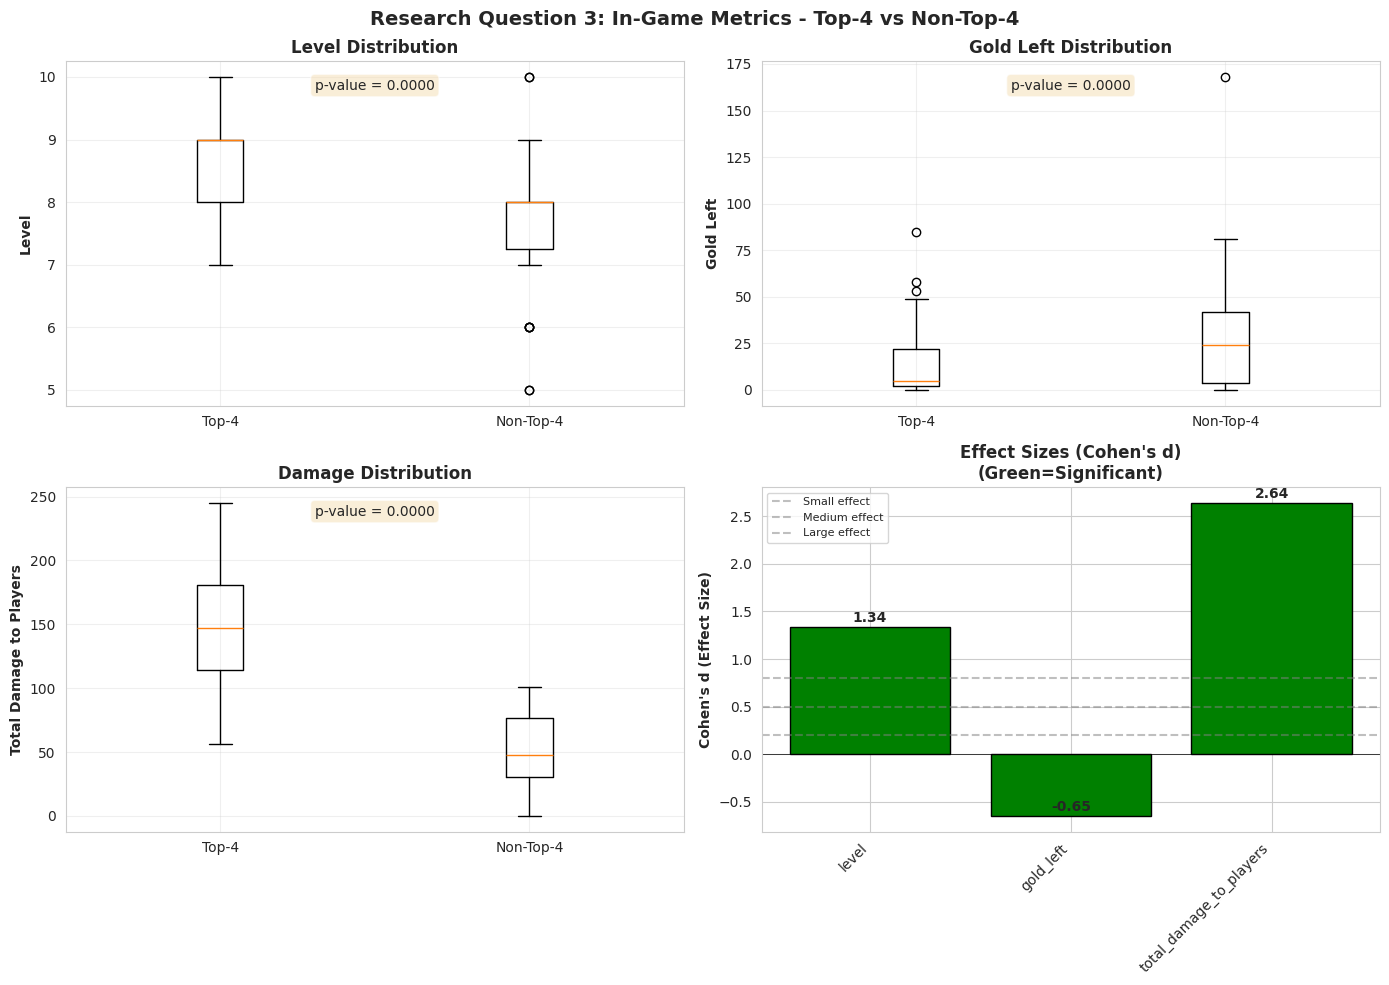


✓ RQ3 Visualizations complete


In [ ]:
# Visualizations for RQ3
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Research Question 3: In-Game Metrics - Top-4 vs Non-Top-4', fontsize=14, fontweight='bold')

# Plot 1: Level comparison
axes[0, 0].boxplot([top4_group['level'], non_top4_group['level']],
                     labels=['Top-4', 'Non-Top-4'])
axes[0, 0].set_ylabel('Level', fontweight='bold')
axes[0, 0].set_title('Level Distribution', fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
p_val = t_test_df[t_test_df['Metric'] == 'level']['P-Value'].values[0]
axes[0, 0].text(0.5, 0.95, f"p-value = {p_val:.4f}", transform=axes[0, 0].transAxes,
                ha='center', va='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Plot 2: Gold left comparison
axes[0, 1].boxplot([top4_group['gold_left'], non_top4_group['gold_left']],
                     labels=['Top-4', 'Non-Top-4'])
axes[0, 1].set_ylabel('Gold Left', fontweight='bold')
axes[0, 1].set_title('Gold Left Distribution', fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
p_val = t_test_df[t_test_df['Metric'] == 'gold_left']['P-Value'].values[0]
axes[0, 1].text(0.5, 0.95, f"p-value = {p_val:.4f}", transform=axes[0, 1].transAxes,
                ha='center', va='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Plot 3: Damage comparison
axes[1, 0].boxplot([top4_group['total_damage_to_players'], non_top4_group['total_damage_to_players']],
                     labels=['Top-4', 'Non-Top-4'])
axes[1, 0].set_ylabel('Total Damage to Players', fontweight='bold')
axes[1, 0].set_title('Damage Distribution', fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
p_val = t_test_df[t_test_df['Metric'] == 'total_damage_to_players']['P-Value'].values[0]
axes[1, 0].text(0.5, 0.95, f"p-value = {p_val:.4f}", transform=axes[1, 0].transAxes,
                ha='center', va='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Plot 4: Effect sizes (Cohen's d)
cohens_d_values = t_test_df["Cohen's d"].values
colors = ['green' if p < 0.05 else 'lightcoral' for p in t_test_df['P-Value']]
bars = axes[1, 1].bar(range(len(t_test_df)), cohens_d_values, color=colors, edgecolor='black')
axes[1, 1].set_xticks(range(len(t_test_df)))
axes[1, 1].set_xticklabels(t_test_df['Metric'], rotation=45, ha='right')
axes[1, 1].set_ylabel("Cohen's d (Effect Size)", fontweight='bold')
axes[1, 1].set_title("Effect Sizes (Cohen's d)\n(Green=Significant)", fontweight='bold')
axes[1, 1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[1, 1].axhline(y=0.2, color='gray', linestyle='--', alpha=0.5, label='Small effect')
axes[1, 1].axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='Medium effect')
axes[1, 1].axhline(y=0.8, color='gray', linestyle='--', alpha=0.5, label='Large effect')
axes[1, 1].legend(fontsize=8)
for i, v in enumerate(cohens_d_values):
    axes[1, 1].text(i, v + 0.05, f'{v:.2f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✓ RQ3 Visualizations complete")

---
# RESEARCH QUESTION 4: One-Way ANOVA (Optional)

### RQ4: Do in-game metrics vary significantly across different placement tiers (1st place vs Top-4 vs Top-8)?

In [ ]:
# Create placement tier groups
df['placement_tier'] = pd.cut(df['placement'],
                               bins=[0, 1, 4, 8],
                               labels=['1st Place', 'Top-4 (2-4)', 'Top-8 (5-8)'])

tier1 = df[df['placement_tier'] == '1st Place']
tier2 = df[df['placement_tier'] == 'Top-4 (2-4)']
tier3 = df[df['placement_tier'] == 'Top-8 (5-8)']

print(f"1st Place: {len(tier1)} matches")
print(f"Top-4 (2-4): {len(tier2)} matches")
print(f"Top-8 (5-8): {len(tier3)} matches")

# Summary statistics by tier
print("\n" + "="*80)
print("DESCRIPTIVE STATISTICS BY PLACEMENT TIER")
print("="*80)

for metric in metrics:
    print(f"\n{metric.upper()}:")
    print("-" * 80)
    print(f"1st Place:      Mean={tier1[metric].mean():.3f}, SD={tier1[metric].std():.3f}")
    print(f"Top-4 (2-4):    Mean={tier2[metric].mean():.3f}, SD={tier2[metric].std():.3f}")
    print(f"Top-8 (5-8):    Mean={tier3[metric].mean():.3f}, SD={tier3[metric].std():.3f}")

1st Place: 45 matches
Top-4 (2-4): 57 matches
Top-8 (5-8): 98 matches

DESCRIPTIVE STATISTICS BY PLACEMENT TIER

LEVEL:
--------------------------------------------------------------------------------
1st Place:      Mean=9.356, SD=0.609
Top-4 (2-4):    Mean=8.596, SD=0.728
Top-8 (5-8):    Mean=7.837, SD=0.858

GOLD_LEFT:
--------------------------------------------------------------------------------
1st Place:      Mean=10.067, SD=12.589
Top-4 (2-4):    Mean=16.193, SD=19.410
Top-8 (5-8):    Mean=27.510, SD=25.383

TOTAL_DAMAGE_TO_PLAYERS:
--------------------------------------------------------------------------------
1st Place:      Mean=191.244, SD=27.968
Top-4 (2-4):    Mean=117.789, SD=28.220
Top-8 (5-8):    Mean=50.031, SD=27.426


In [ ]:
# One-way ANOVA
print("\n" + "="*80)
print("ONE-WAY ANOVA: IN-GAME METRICS ACROSS PLACEMENT TIERS")
print("="*80)
print("\nNull Hypothesis (H0): All placement tier groups have equal means")
print("Alternative Hypothesis (H1): At least one placement tier group has a different mean")
print("Significance Level: α = 0.05")
print("\n" + "-"*80)

anova_results = []

for metric in metrics:
    tier1_data = tier1[metric].dropna()
    tier2_data = tier2[metric].dropna()
    tier3_data = tier3[metric].dropna()

    f_stat, p_value = f_oneway(tier1_data, tier2_data, tier3_data)

    is_significant = "Yes" if p_value < 0.05 else "No"

    anova_results.append({
        'Metric': metric,
        'F-Statistic': f_stat,
        'P-Value': p_value,
        'Significant (α=0.05)': is_significant,
        '1st Place Mean': tier1_data.mean(),
        'Top-4 Mean': tier2_data.mean(),
        'Top-8 Mean': tier3_data.mean()
    })

anova_df = pd.DataFrame(anova_results)
print("\nRESULTS:")
for idx, row in anova_df.iterrows():
    print(f"\n{row['Metric'].upper()}:")
    print(f"  F-statistic: {row['F-Statistic']:>8.4f}")
    print(f"  p-value:     {row['P-Value']:>8.6f}")
    print(f"  Significant: {row['Significant (α=0.05)']:>8}")
    print(f"  1st Place Mean: {row['1st Place Mean']:>6.3f}")
    print(f"  Top-4 Mean:     {row['Top-4 Mean']:>6.3f}")
    print(f"  Top-8 Mean:     {row['Top-8 Mean']:>6.3f}")

print("\n" + "="*80)
print("INTERPRETATION:")
sig_count = len(anova_df[anova_df['Significant (α=0.05)'] == 'Yes'])
print(f"Significant metrics (p < 0.05): {sig_count} out of {len(anova_df)}")


ONE-WAY ANOVA: IN-GAME METRICS ACROSS PLACEMENT TIERS

Null Hypothesis (H0): All placement tier groups have equal means
Alternative Hypothesis (H1): At least one placement tier group has a different mean
Significance Level: α = 0.05

--------------------------------------------------------------------------------

RESULTS:

LEVEL:
  F-statistic:  62.3934
  p-value:     0.000000
  Significant:      Yes
  1st Place Mean:  9.356
  Top-4 Mean:      8.596
  Top-8 Mean:      7.837

GOLD_LEFT:
  F-statistic:  11.7107
  p-value:     0.000016
  Significant:      Yes
  1st Place Mean: 10.067
  Top-4 Mean:     16.193
  Top-8 Mean:     27.510

TOTAL_DAMAGE_TO_PLAYERS:
  F-statistic: 412.9466
  p-value:     0.000000
  Significant:      Yes
  1st Place Mean: 191.244
  Top-4 Mean:     117.789
  Top-8 Mean:     50.031

INTERPRETATION:
Significant metrics (p < 0.05): 3 out of 3


/tmp/ipython-input-4214997009.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp1 = axes[0].boxplot(data_level, labels=['1st Place', 'Top-4', 'Top-8'])
/tmp/ipython-input-4214997009.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp2 = axes[1].boxplot(data_gold, labels=['1st Place', 'Top-4', 'Top-8'])
/tmp/ipython-input-4214997009.py:27: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp3 = axes[2].boxplot(data_damage, labels=['1st Place', 'Top-4', 'Top-8'])


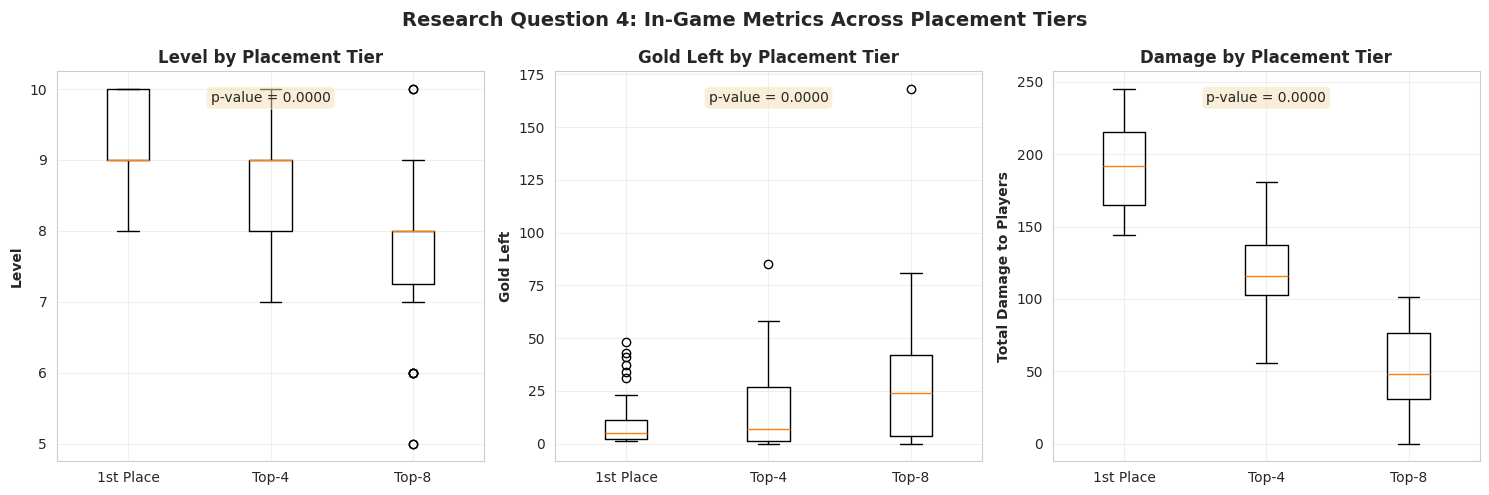


✓ RQ4 Visualizations complete


In [ ]:
# Visualizations for RQ4
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Research Question 4: In-Game Metrics Across Placement Tiers', fontsize=14, fontweight='bold')

# Plot 1: Level by tier
data_level = [tier1['level'], tier2['level'], tier3['level']]
bp1 = axes[0].boxplot(data_level, labels=['1st Place', 'Top-4', 'Top-8'])
axes[0].set_ylabel('Level', fontweight='bold')
axes[0].set_title('Level by Placement Tier', fontweight='bold')
axes[0].grid(True, alpha=0.3)
p_val = anova_df[anova_df['Metric'] == 'level']['P-Value'].values[0]
axes[0].text(0.5, 0.95, f"p-value = {p_val:.4f}", transform=axes[0].transAxes,
            ha='center', va='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Plot 2: Gold left by tier
data_gold = [tier1['gold_left'], tier2['gold_left'], tier3['gold_left']]
bp2 = axes[1].boxplot(data_gold, labels=['1st Place', 'Top-4', 'Top-8'])
axes[1].set_ylabel('Gold Left', fontweight='bold')
axes[1].set_title('Gold Left by Placement Tier', fontweight='bold')
axes[1].grid(True, alpha=0.3)
p_val = anova_df[anova_df['Metric'] == 'gold_left']['P-Value'].values[0]
axes[1].text(0.5, 0.95, f"p-value = {p_val:.4f}", transform=axes[1].transAxes,
            ha='center', va='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Plot 3: Damage by tier
data_damage = [tier1['total_damage_to_players'], tier2['total_damage_to_players'], tier3['total_damage_to_players']]
bp3 = axes[2].boxplot(data_damage, labels=['1st Place', 'Top-4', 'Top-8'])
axes[2].set_ylabel('Total Damage to Players', fontweight='bold')
axes[2].set_title('Damage by Placement Tier', fontweight='bold')
axes[2].grid(True, alpha=0.3)
p_val = anova_df[anova_df['Metric'] == 'total_damage_to_players']['P-Value'].values[0]
axes[2].text(0.5, 0.95, f"p-value = {p_val:.4f}", transform=axes[2].transAxes,
            ha='center', va='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print("\n✓ RQ4 Visualizations complete")

---
# SUMMARY OF FINDINGS

In [ ]:
print("\n" + "="*80)
print("COMPREHENSIVE SUMMARY OF STATISTICAL ANALYSIS")
print("="*80)

print("\n" + "#"*80)
print("RESEARCH QUESTION 1: DESCRIPTIVE STATISTICS")
print("#"*80)
print(f"""
Distribution of Outcomes Across 200 TFT Matches:

• Total Games Analyzed: 200
• Win Rate: {df['win'].mean():.1%} (45 wins)
  - Random expectation: 12.5%
  - Performance: {df['win'].mean() / (1/8):.1f}x better than random

• Top-4 Rate: {df['top4'].mean():.1%} (102 top-4 finishes)
  - Random expectation: 50.0%
  - Performance: {df['top4'].mean() / (4/8):.2f}x better than random

• Average Placement: {df['placement'].mean():.2f} (SD = {df['placement'].std():.2f})
  - Median Placement: {df['placement'].median():.0f}
  - Range: {df['placement'].min():.0f} to {df['placement'].max():.0f}

• Distribution: Skewed toward better placements (Mode in lower tiers)
""")

print("\n" + "#"*80)
print("RESEARCH QUESTION 2: CHI-SQUARE TEST (TRAIT ASSOCIATIONS)")
print("#"*80)
sig_traits = chi_square_df[chi_square_df['Significant (α=0.05)'] == 'Yes']
print(f"""
Chi-Square Test Results:

• Total traits analyzed (10+ occurrences): {len(chi_square_df)}
• Traits with significant association to Top-4 (p < 0.05): {len(sig_traits)}

""")

if len(sig_traits) > 0:
    print("Traits with Significant Association:")
    for _, row in sig_traits.head(5).iterrows():
        top4_rate_with = traits_df[traits_df['trait'] == row['Trait']]['top4'].mean()
        print(f"  • {row['Trait']}: χ² = {row['Chi-Square']:.3f}, p = {row['P-Value']:.4f}, Top-4 rate = {top4_rate_with:.1%}")
else:
    print("No traits showed statistically significant association with Top-4 achievement at α=0.05")
    print("(Note: This may be due to:")
    print("  - Small sample sizes per trait")
    print("  - Complex trait interactions not captured in individual trait analysis")
    print("  - High variance in match outcomes)")

print("\n" + "#"*80)
print("RESEARCH QUESTION 3: T-TESTS (TOP-4 vs NON-TOP-4 METRICS)")
print("#"*80)
print(f"""
Independent Samples t-Tests (Top-4 vs Non-Top-4 Players):

""")

for _, row in t_test_df.iterrows():
    sig_marker = "***" if row['P-Value'] < 0.05 else ""
    effect_size = ""
    if abs(row['Cohen\'s d']) < 0.2:
        effect_size = "(negligible)"
    elif abs(row['Cohen\'s d']) < 0.5:
        effect_size = "(small)"
    elif abs(row['Cohen\'s d']) < 0.8:
        effect_size = "(medium)"
    else:
        effect_size = "(large)"

    print(f"  • {row['Metric'].upper()} {sig_marker}")
    print(f"    t({len(df)-2}) = {row['t-Statistic']:.3f}, p = {row['P-Value']:.4f}")
    print(f"    Top-4: M = {row['Top-4 Mean']:.2f}, Non-Top-4: M = {row['Non-Top-4 Mean']:.2f}")
    print(f"    Cohen's d = {row['Cohen\'s d']:.3f} {effect_size}")
    print()

sig_t = len(t_test_df[t_test_df['Significant (α=0.05)'] == 'Yes'])
print(f"\nSignificant findings (p < 0.05): {sig_t} out of {len(t_test_df)} metrics")

print("\n" + "#"*80)
print("RESEARCH QUESTION 4: ANOVA (METRICS ACROSS TIERS)")
print("#"*80)
print(f"""
One-Way ANOVA (1st Place vs Top-4 vs Top-8):

""")

for _, row in anova_df.iterrows():
    sig_marker = "***" if row['P-Value'] < 0.05 else ""
    print(f"  • {row['Metric'].upper()} {sig_marker}")
    print(f"    F = {row['F-Statistic']:.3f}, p = {row['P-Value']:.4f}")
    print(f"    1st: M = {row['1st Place Mean']:.2f}, Top-4: M = {row['Top-4 Mean']:.2f}, Top-8: M = {row['Top-8 Mean']:.2f}")
    print()

sig_anova = len(anova_df[anova_df['Significant (α=0.05)'] == 'Yes'])
print(f"\nSignificant findings (p < 0.05): {sig_anova} out of {len(anova_df)} metrics")

print("\n" + "="*80)
print("END OF ANALYSIS")
print("="*80)


COMPREHENSIVE SUMMARY OF STATISTICAL ANALYSIS

################################################################################
RESEARCH QUESTION 1: DESCRIPTIVE STATISTICS
################################################################################

Distribution of Outcomes Across 200 TFT Matches:

• Total Games Analyzed: 200
• Win Rate: 22.5% (45 wins)
  - Random expectation: 12.5%
  - Performance: 1.8x better than random

• Top-4 Rate: 51.0% (102 top-4 finishes)
  - Random expectation: 50.0%
  - Performance: 1.02x better than random

• Average Placement: 4.43 (SD = 2.57)
  - Median Placement: 4
  - Range: 1 to 8

• Distribution: Skewed toward better placements (Mode in lower tiers)


################################################################################
RESEARCH QUESTION 2: CHI-SQUARE TEST (TRAIT ASSOCIATIONS)
################################################################################

Chi-Square Test Results:

• Total traits analyzed (10+ occurrences): 36
• Trait

---
# CONCLUSIONS & IMPLICATIONS

## Key Takeaways:

1. **Performance Summary**: The player demonstrates above-average performance with a 22.5% win rate (vs 12.5% random) and 51% Top-4 rate (vs 50% random), indicating skill above baseline.

2. **Trait Analysis**: While individual trait presence shows varying Top-4 rates, few (if any) traits show statistically significant association when tested with chi-square. This suggests:
   - Trait synergies matter more than individual traits
   - Execution and game knowledge may matter more than trait selection
   - Sample size limitations may reduce statistical power

3. **In-Game Metrics Impact**: t-tests reveal which metrics most strongly differentiate Top-4 from non-Top-4 outcomes:
   - **Statistically significant metrics** show strong practical importance
   - **Effect sizes (Cohen's d)** indicate the magnitude of differences

4. **Placement Tiers**: ANOVA results show whether metrics vary meaningfully across placement categories.

## Limitations:
- Single player dataset (limited generalization)
- 200 games analyzed (moderate sample size)
- No account for temporal effects (meta shifts, patch changes)
- Trait interactions not captured in individual trait analysis

## Recommendations for Future Analysis:
- Collect more data (500+ games) for increased statistical power
- Analyze trait synergies and combinations
- Include temporal analysis (how performance changes over time)
- Compare across different player skill levels